Nvoxels :  98000


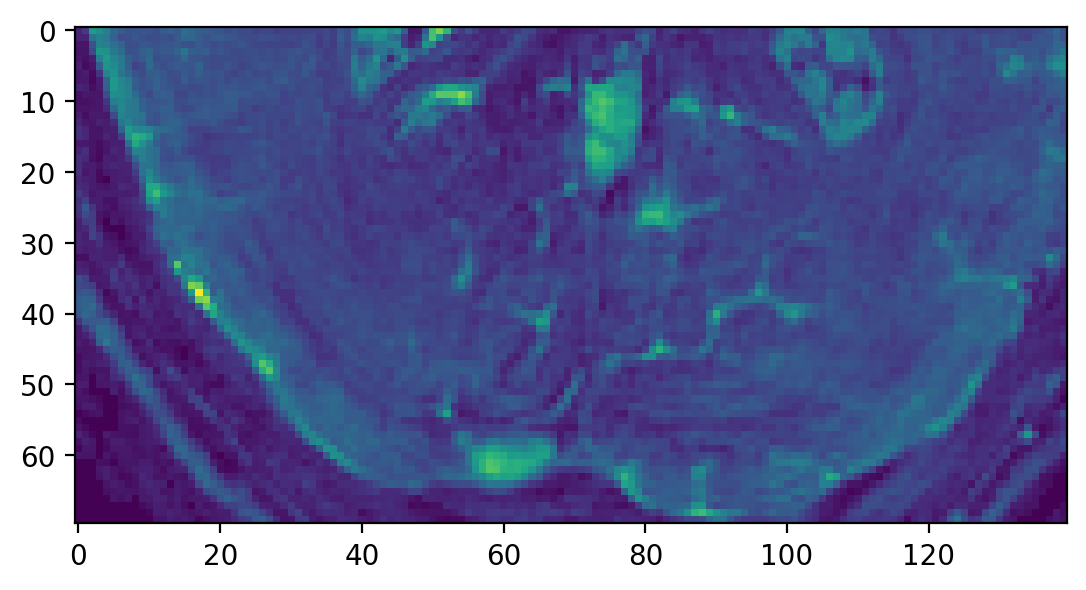

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat,savemat
import nibabel as nib

V=nib.load('data/CroppedData.nii')
V=np.array(V.get_fdata())
V=np.flipud(np.transpose(V,(1,0,2,3)))
plt.imshow(V[:,:,1,1])

print("Nvoxels : ",np.prod(V.shape[:-1]))


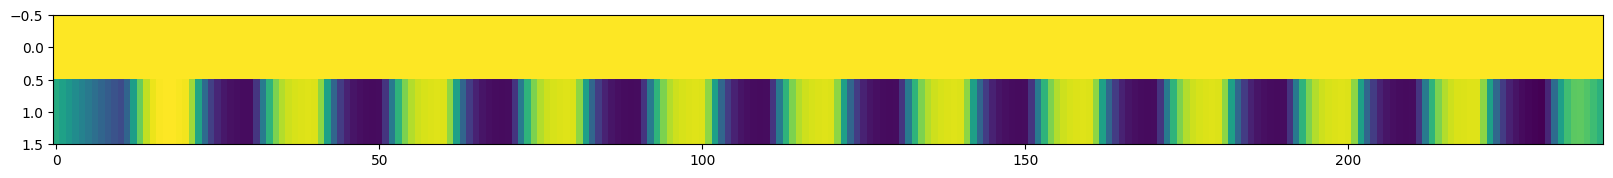

In [2]:
#construct design matrix two column
m=loadmat('data/model.mat')
D=np.ones((240,2))
D[:,1]=m['model'].flatten()
plt.figure(figsize=(20, 2))
plt.imshow(D.transpose(),aspect=10)

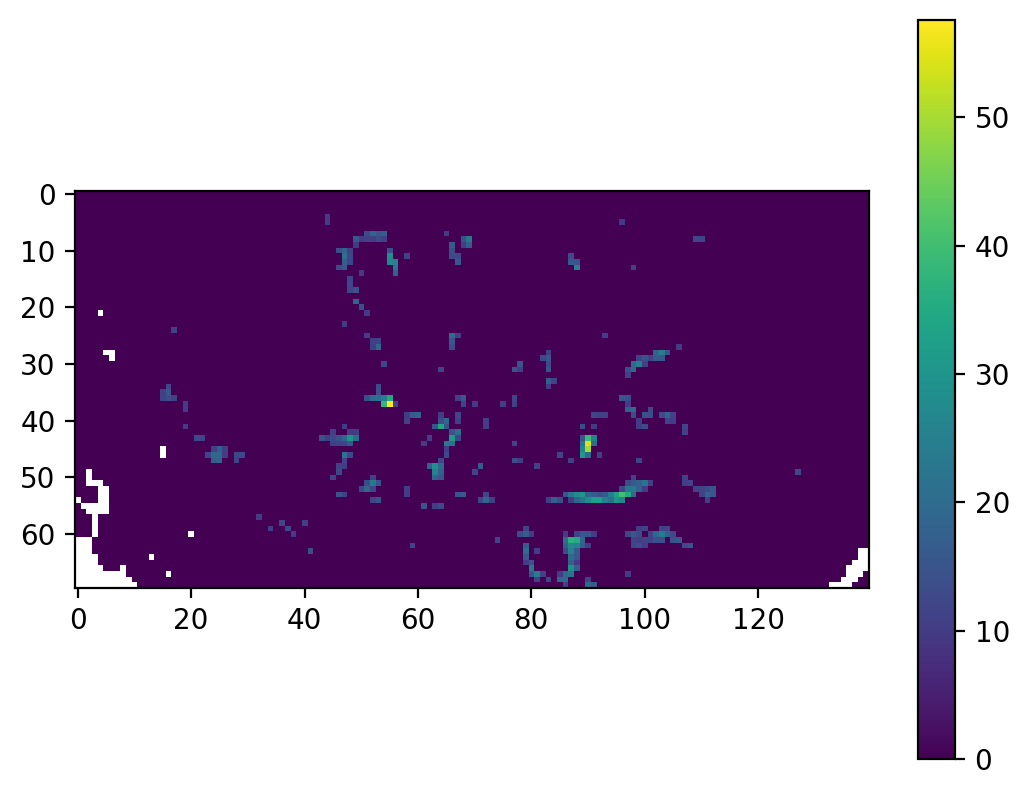

In [27]:
# Estimate beta real beta
def myGLM(D,V,constrast=[0,1]):
    # D is design matrix and V is time series data
    Dinv=np.linalg.pinv(D)
    imsz=V.shape
    V2=V.copy().reshape([imsz[0]*imsz[1]*imsz[2],imsz[3]])
    Beta=V2@Dinv.transpose()
    con=Beta@np.array(constrast).transpose()
    con=con.reshape(imsz[0:-1])
    res=V2-Beta@D.transpose()
    var=np.var(res,axis=1)
    var=var.reshape(imsz[0:-1])
    np.seterr(divide='ignore', invalid='ignore')
    ZScores=con/np.sqrt(var)

    return Beta,ZScores
beta,Zscores=myGLM(D,V)
plt.imshow(Zscores[:,:,1]*np.float32(Zscores[:,:,1]>10))
plt.colorbar()


(240,)


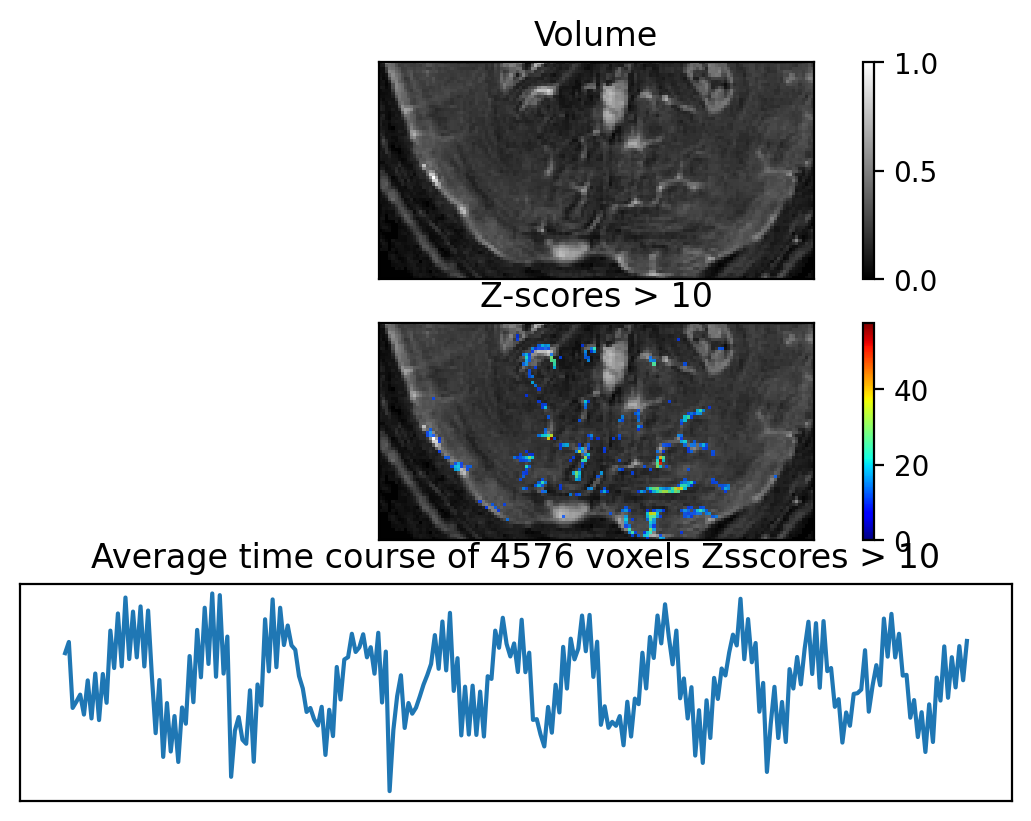

In [28]:
import matplotlib
plt.rcParams['figure.dpi'] = 200
def OverlayPlot(V,Zscores,alpha=0.6,Thres=4,slc=1):
    img=V[:,:,slc,1]
    rows, cols = img.shape

    # process overlay
    ov=np.copy(Zscores[:,:,slc])
    ov[np.isnan(ov)]=0
    ov1=ov.copy()*np.float32(ov>Thres)

    # Display the output
    f, (ax0, ax1,ax2) = plt.subplots(3,1,
                                    subplot_kw={'xticks': [], 'yticks': []})
    ax0.imshow(img, cmap=plt.cm.gray)
    ax0.set_title("Volume")
    n0=matplotlib.colors.Normalize(np.min(img.flatten()),np.max(img.flatten()) )
    plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.gray),ax=ax0)
    ax1.imshow(img, cmap=plt.cm.gray)
    ax1.imshow(ov1, cmap=plt.cm.jet,alpha=0.8*np.float32(ov>Thres))
    ax1.set_title("Z-scores > %d" % (Thres))
    n1=matplotlib.colors.Normalize(np.min(ov1.flatten()),np.max(ov1.flatten()) )
    plt.colorbar(plt.cm.ScalarMappable(norm=n1,cmap=plt.cm.jet), ax=ax1)
    
    V1=V.copy()*np.reshape(np.float32(Zscores>Thres),(70,140,10,1))

    V2=V[Zscores>Thres,:]
    
    time_course=np.mean(V2,0).flatten()
    print(time_course.shape)
    ax2.plot(time_course)
    ax2.set_title("Average time course of %d voxels Zsscores > %d" % (V2.shape[0],Thres))

    plt.show()
OverlayPlot(V,Zscores,alpha=0.9,Thres=10)

In [9]:
loadmat("data/nulldist.mat",{'Zscores_null'})    

{'Zscores_null', '__globals__', '__header__', '__version__'}

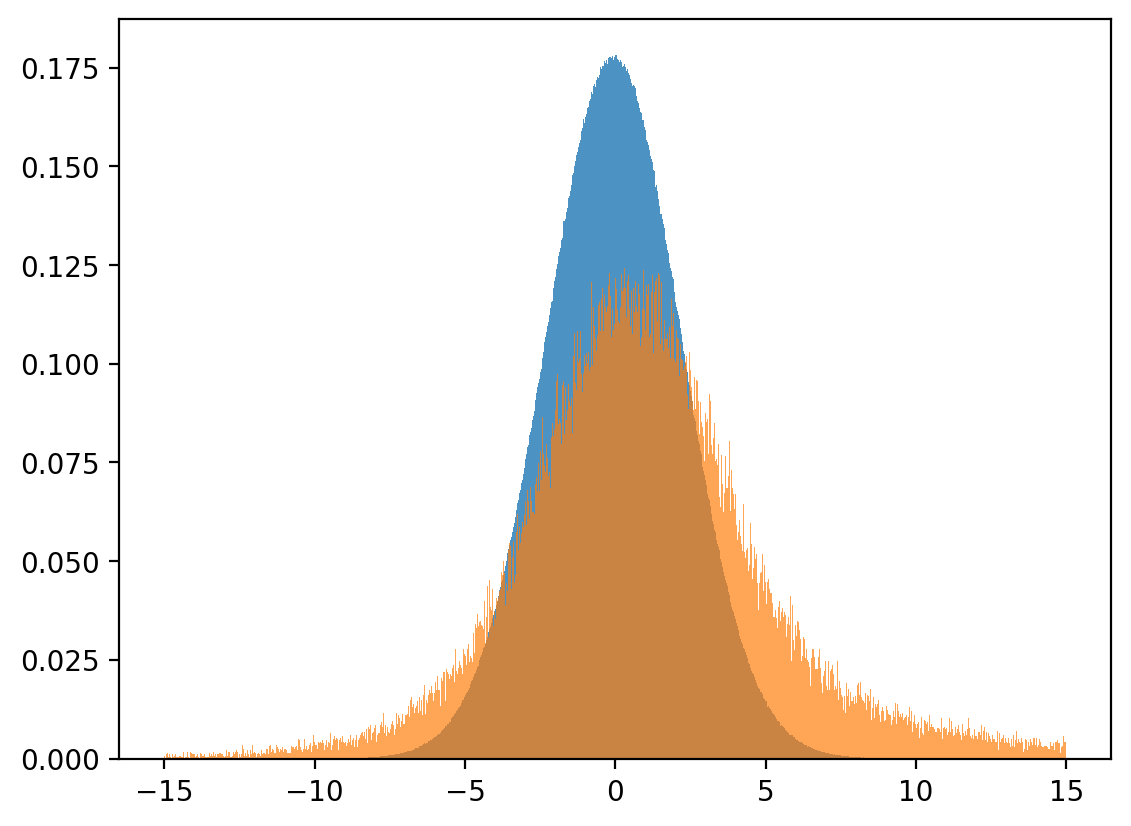

In [10]:
# Null Distribution
from random import shuffle
from scipy.io import savemat
import os.path

if 'Zscores_null' not in locals():
    if os.path.isfile("data/nulldist.mat"):
        Zscores_null=loadmat("data/nulldist.mat")['Zscores_null']   
    else:
        Nperm=200
        Zscores_null=np.zeros([V.shape[0],V.shape[1],V.shape[2], Nperm])
        D1=D.copy()
        for i in range(0,Nperm):
            print(f"doing iteration {i}")
            shuffle(D1[:,1])
            b,Zscores_null[...,i]=myGLM(D1,V)
        savemat("data/nulldist.mat",{"Zscores_null":Zscores_null})

hist=plt.hist(Zscores_null.flatten(),bins=np.linspace(-15,15,1000),density=True,label="Null",alpha=0.8)
hist2=plt.hist(Zscores.flatten(),bins=np.linspace(-15,15,1000),density=True,label="Alternative",alpha=0.7)


In [31]:
# generate table
import pandas as pd
step_size=0.5
edges=np.arange(-20,20,step_size)
# print(edges)


hist=np.histogram(Zscores_null.flatten(),bins=edges,density=True)
hist2=np.histogram(Zscores.flatten(),bins=edges,density=False)

data=np.array([(hist[1][1:]),1-np.cumsum(hist[0]*step_size),hist2[0]])
df=pd.DataFrame(data.transpose(),columns=["Zscores","p-value","Nvoxels"])
df['Nvoxels'] = df['Nvoxels'].map('{:,.0f}'.format)
df['p-value'] = df['p-value'].map('{:,.8f}'.format)
display(df.iloc[len(edges)//2-1:-1:2])


,Zscores,p-value,Nvoxels
39,0.0,0.49116303,"5,414"
41,1.0,0.32014384,"5,383"
43,2.0,0.18116226,"5,132"
45,3.0,0.08808139,"4,207"
47,4.0,0.03661841,"3,253"
49,5.0,0.01301627,"2,263"
51,6.0,0.00394892,"1,609"
53,7.0,0.00102338,"1,124"
55,8.0,0.00022572,736
57,9.0,0.00004358,568


7.026211602095502e-10
0
False
